In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import numpy as np
import os
import yaml

In [2]:
from distgen import Generator
from distgen.physical_constants import unit_registry, PHYSICAL_CONSTANTS
from distgen.dist import NormRad, DistRad, UniformRad

hbar = PHYSICAL_CONSTANTS["reduced Planck constant"].to("nm * eV/c")

In [3]:
laser_sigma_xy = 1.0 * unit_registry('um')
emitter_radius = 500 * unit_registry('nm') / 2

emitter_QE = 10 * unit_registry('percent')
mask_QE = emitter_QE / 2

laserDist = NormRad(verbose=0, **{'sigma_xy': laser_sigma_xy})
emitterDist = NormRad(verbose=0, **{'sigma_xy': laser_sigma_xy, 'truncation_radius_right': emitter_radius})
maskDist = NormRad(verbose=0, **{'sigma_xy': laser_sigma_xy, 'truncation_radius_left': emitter_radius})

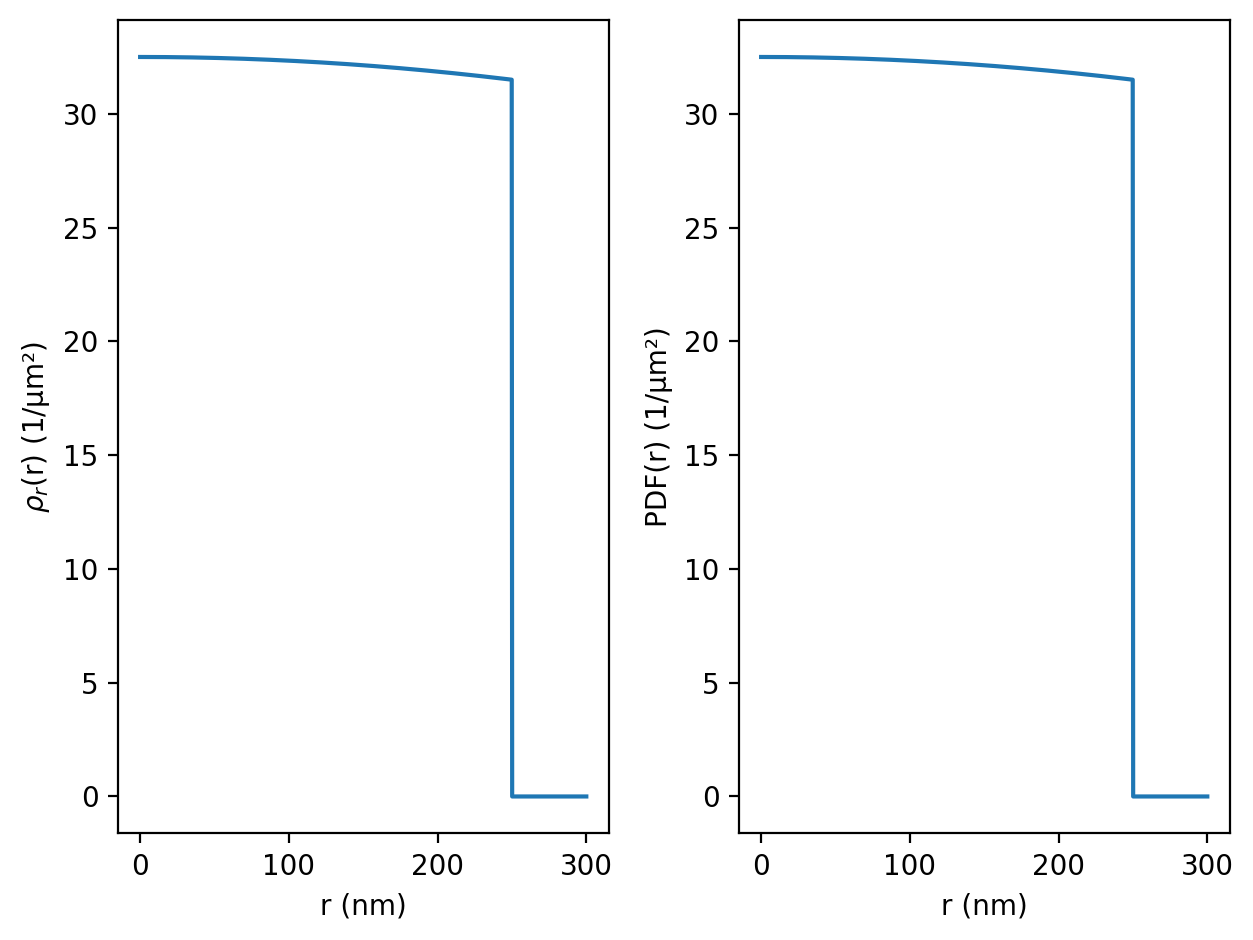

In [4]:
emitterDist.plot_pdf()

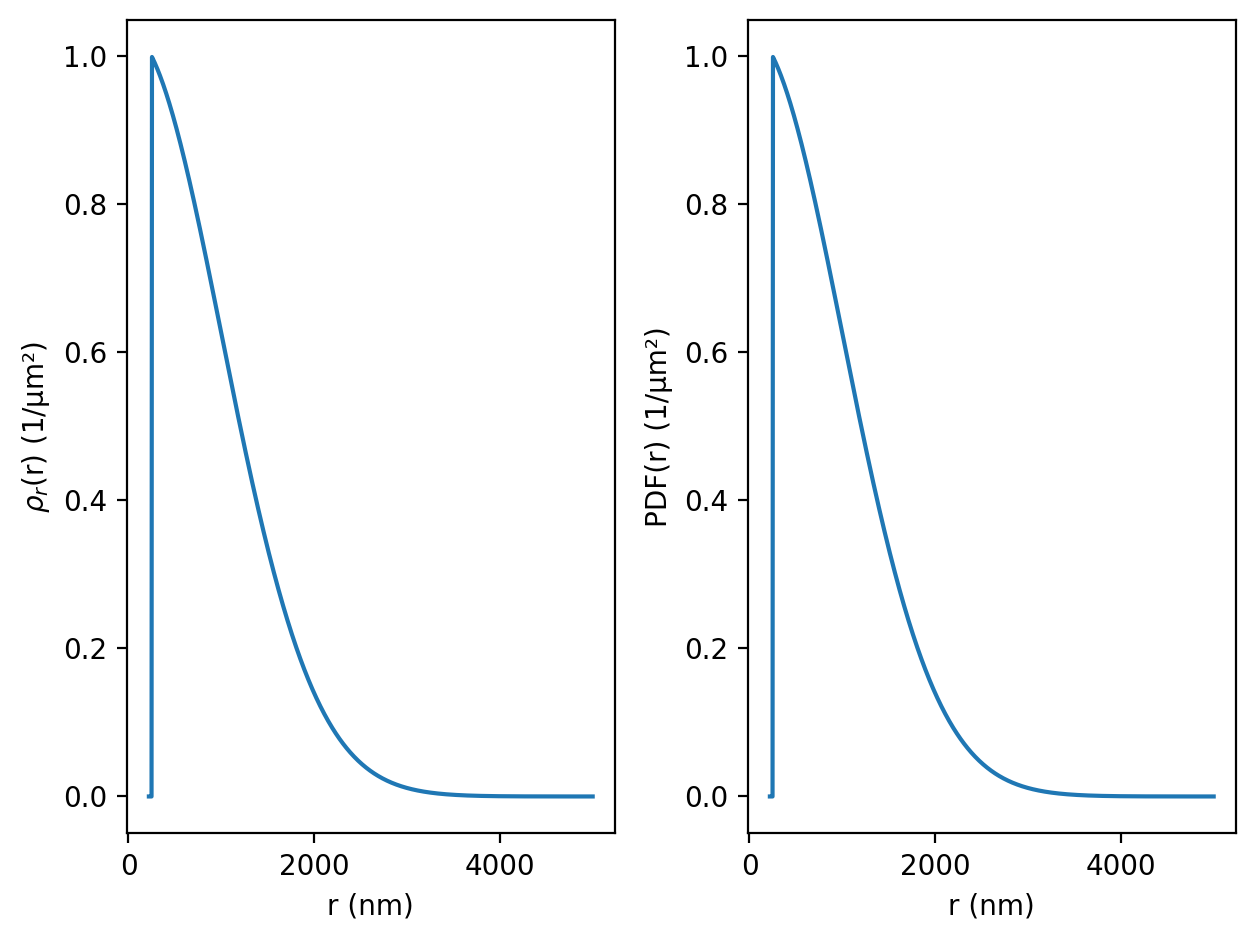

In [5]:
maskDist.plot_pdf()

Text(0.5, 0, '$r/\\sigma_{x,y}$')

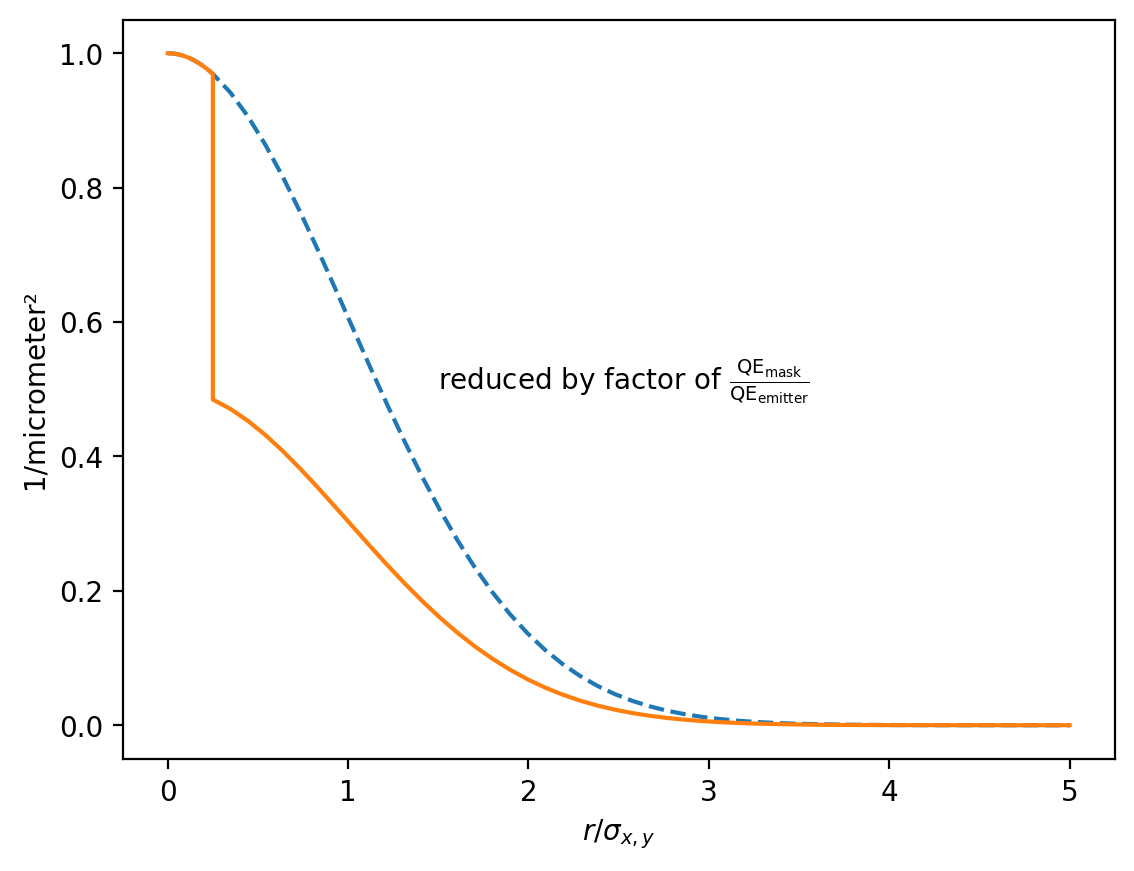

In [6]:
r1 = np.linspace(0, emitter_radius, 1000)
r2 = np.linspace(emitter_radius, 5 * laser_sigma_xy)

Pr1 = emitterDist.rho(r1)
Pr2 = maskDist.rho(r2).to(Pr1.units)

Pr1 = Pr1/Pr1[-1].magnitude
Pr2 = (mask_QE/emitter_QE) * (Pr1[-1]/Pr2[0]) * Pr2

r = np.concatenate( (r1, r2) )
Pr = np.concatenate( (Pr1, Pr2)) 
norm = np.trapezoid(r*Pr, r)
Pr = Pr/norm


plt.text(1.5, 0.5, r'reduced by factor of $\frac{\text{QE}_{\text{mask}}}{\text{QE}_{\text{emitter}}}$')


plt.plot((r/laser_sigma_xy).to('dimensionless'), laserDist.rho(r), '--', label='laser profile')
plt.plot((r/laser_sigma_xy).to('dimensionless'), Pr * (laserDist.rho(r)[0]/Pr[0]), label='laser profile w/QE map')
plt.xlabel(r'$r/\sigma_{x,y}$')

#plt.text(1, 5, 'q')
#plt.legend()

In [7]:
print(np.trapezoid(r*Pr, r))

f1 = np.trapezoid(r1*Pr1/norm, r1)
f2 = np.trapezoid(r2*Pr2/norm, r2)

f1, f2, f1 + f2

1.0000000000000002 dimensionless


(<Quantity(0.0597383281, 'dimensionless')>,
 <Quantity(0.940261672, 'dimensionless')>,
 <Quantity(1.0, 'dimensionless')>)

In [8]:
inputs = {
    'n_particle': 1000,
    'species': 'electron',
    'r_dist': {'type': 'radial', 'r':r, 'Pr':Pr},
    'random': {'type': 'hammersley'},
    'start': {'MTE': {'value': 130, 'units': 'meV'}, 'type': 'cathode'},
    'total_charge': {'value':1.602176634e-17, 'units': 'C'},
    'spin_polarization': 0.35

}

D = Generator(inputs, verbose=0)
P = D.run()

(np.float64(-3.8209085572888952),
 np.float64(3.3200150925629535),
 np.float64(-3.733439160279522),
 np.float64(3.429449352170041))

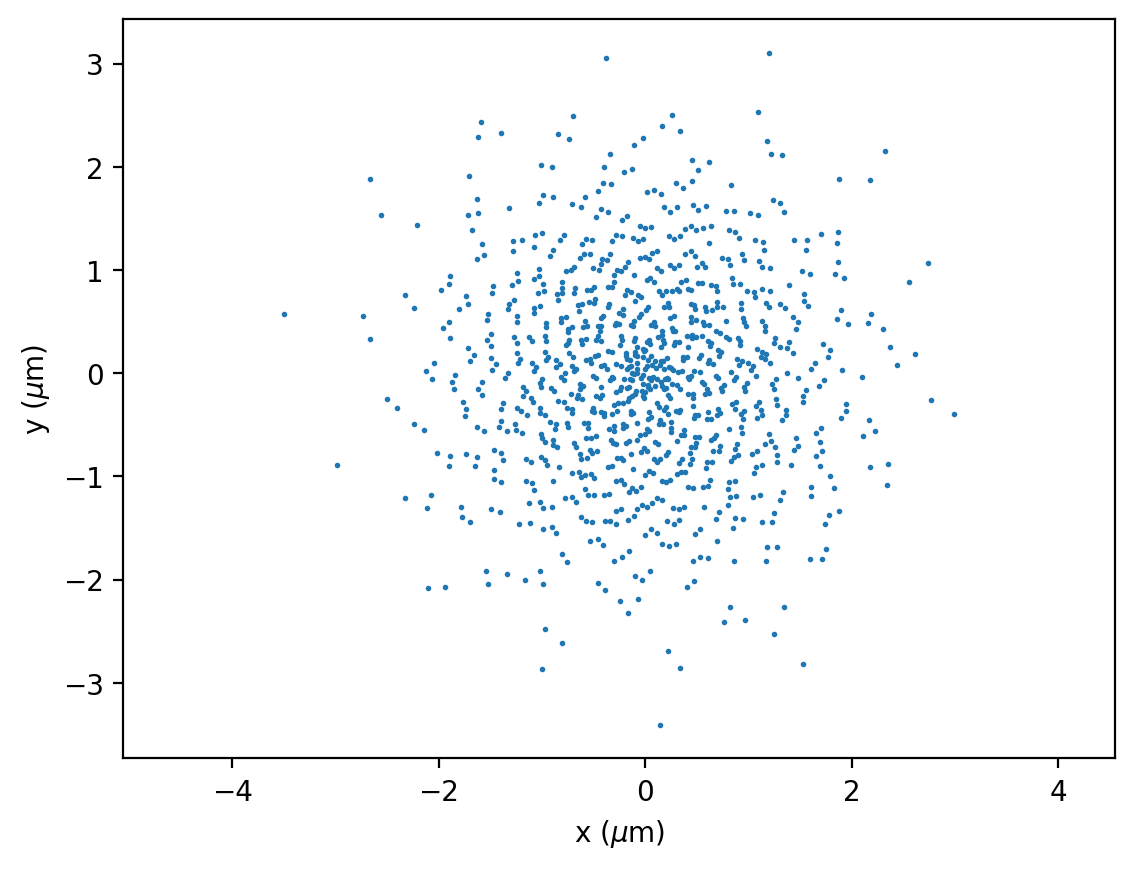

In [9]:
plt.plot(P['x'] * 1e6, P['y']*1e6, '.', markersize=2)
plt.xlabel(r'x ($\mu$m)')
plt.ylabel(r'y ($\mu$m)')
plt.axis('equal')

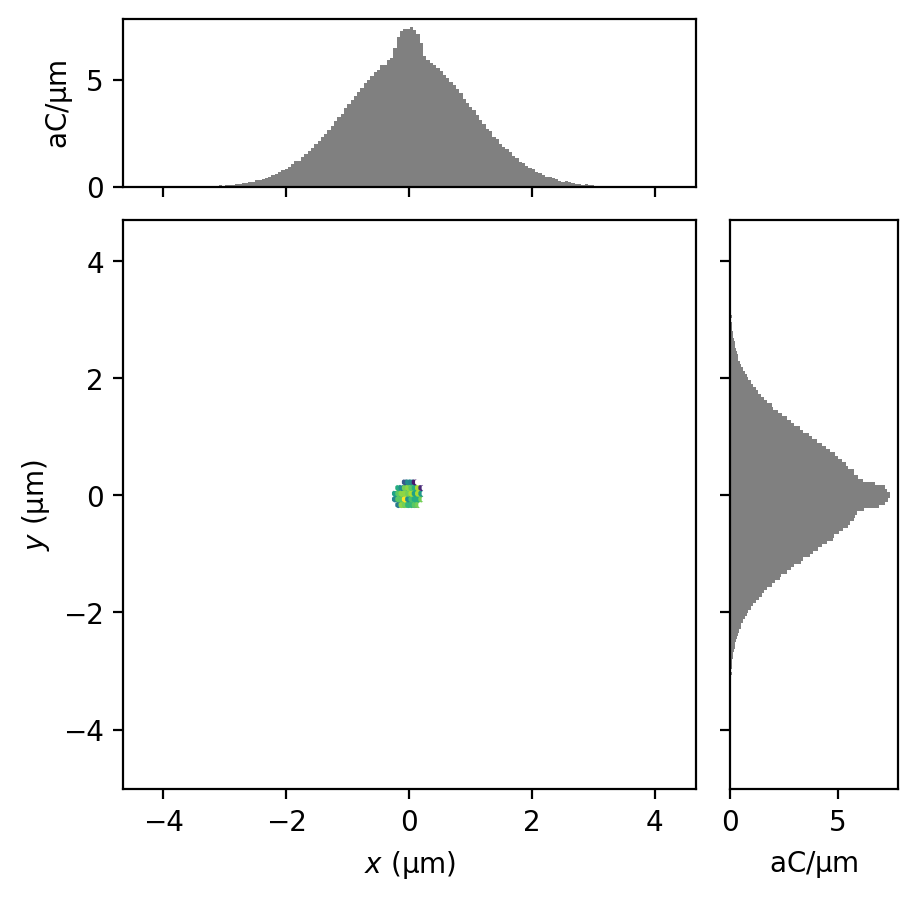

In [10]:
D['n_particle'] = 100_000
D.run()
D.particles.plot('x', 'y', figsize=(5,5))

Text(0, 0.5, '$y/\\sigma_{x,y}$')

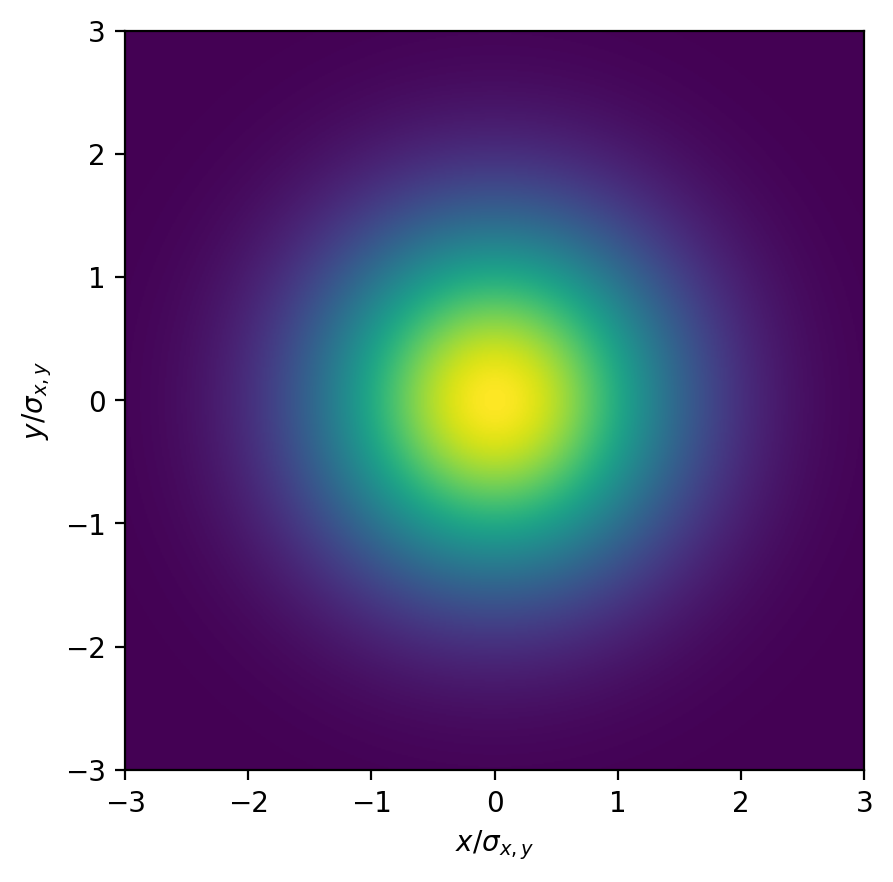

In [11]:
Nsigma = 3
Npts = 500

x = laser_sigma_xy * np.linspace(-Nsigma, Nsigma, Npts)
y = x

plt.imshow(laserDist.rho_xy(x, y).magnitude, extent=[-Nsigma, Nsigma, -Nsigma, Nsigma])
plt.xlabel(r'$x/\sigma_{x,y}$')
plt.ylabel(r'$y/\sigma_{x,y}$')

Text(0, 0.5, '$y/\\sigma_{x,y}$')

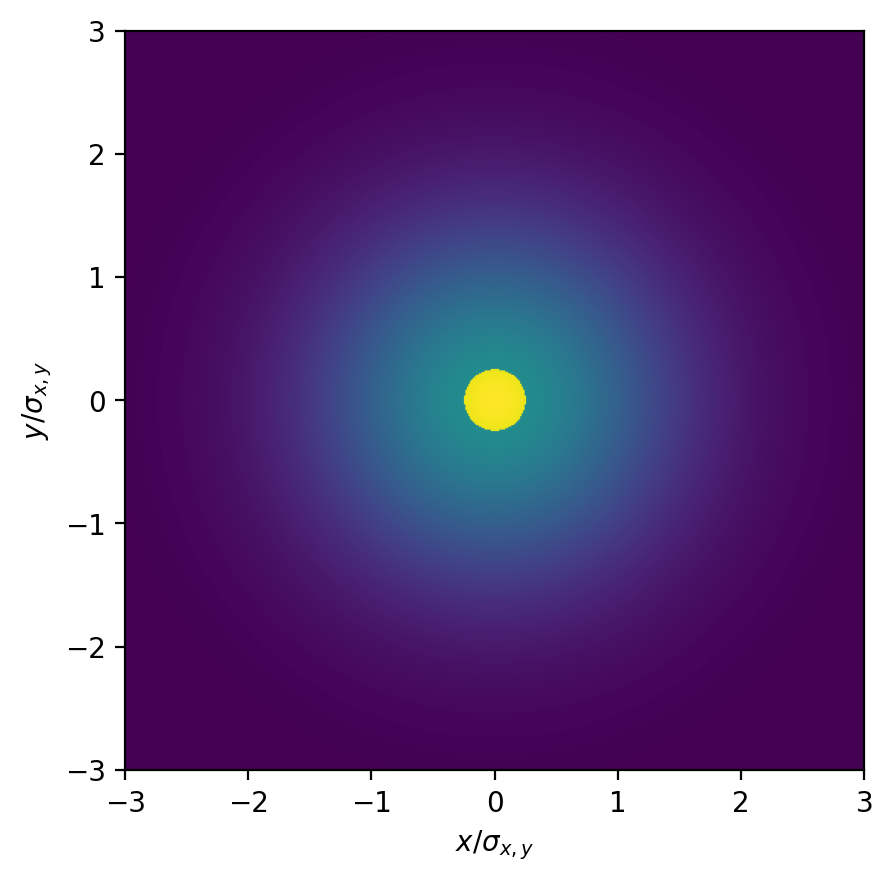

In [12]:
qeMap = DistRad(rs=r, Pr=Pr)

plt.imshow(qeMap.rho_xy(x, y).magnitude, extent=[-Nsigma, Nsigma, -Nsigma, Nsigma])
plt.xlabel(r'$x/\sigma_{x,y}$')
plt.ylabel(r'$y/\sigma_{x,y}$')

Text(0, 0.5, '$y/\\sigma_{x,y}$')

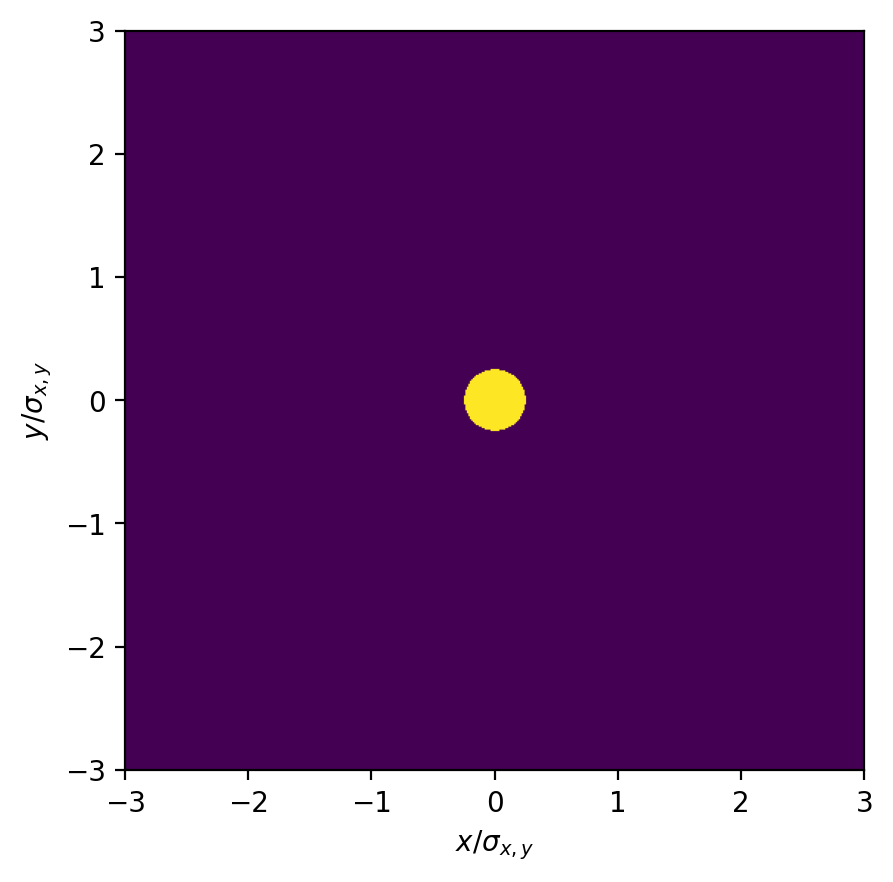

In [13]:
emitterDist2 = UniformRad(max_r=emitter_radius)
maskDist2 = UniformRad(min_r=emitter_radius, max_r=18*emitter_radius)

plt.imshow((emitterDist2.rho_xy(x, y) + maskDist2.rho_xy(x, y)).magnitude, extent=[-Nsigma, Nsigma, -Nsigma, Nsigma])
plt.xlabel(r'$x/\sigma_{x,y}$')
plt.ylabel(r'$y/\sigma_{x,y}$')

In [81]:
def generate_beam_from_well(n_particle, RoSigma, sp1, sp2, RQE, MTE1, MTE2):
    
    F2 = np.exp(-RoSigma**2/2)

    n_particle1 = int(np.round( n_particle * (1 - F2) / (1 + (RQE-1) * F2) ))
    n_particle2 = n_particle - n_particle1

    sigma = 1 * unit_registry('um')
    R = RoSigma * sigma
    
    laserDist = NormRad(verbose=0, **{'sigma_xy': sigma})
    emitterDist = NormRad(verbose=0, **{'sigma_xy': sigma, 'truncation_radius_right': R})
    maskDist = NormRad(verbose=0, **{'sigma_xy': sigma, 'truncation_radius_left': R})
    
    inputs1 = f"""
    n_particle: {n_particle1}
    total_charge: {1.602176634e-19*n_particle1} C
    start:
        type: cathode
        MTE: {MTE1}
    species: electron
    r_dist:
        type: rg
        sigma_xy: {sigma}
        truncation_radius_right: {R}          
    random: 
        type: hammersley
    spin_polarization: {sp1}
    fix_avg_and_stds: False
    """

    inputs2 = f"""
    n_particle: {n_particle2}
    total_charge: {1.602176634e-19*n_particle2} C
    start:
        type: cathode
        MTE: {MTE2}
    #p_polar_angle_dist:
    #    type: fermi_dirac_3step_barrier_photocathode
        #photon_wavelength: 495.937 nm # 780 nm 
        #temperature: 300 K
        #work_function: 2 eV # 5 eV
        #fermi_energy: 6 eV # 10 eV
        #photon_wavelength: 780 nm 
        #temperature: 300 K
        #work_function: 5 eV
        #fermi_energy: 9 eV
        #n_tails: 140
    species: electron
    r_dist:
        type: rg
        sigma_xy: {sigma}
        truncation_radius_left: {R} 
            
    random: 
        type: hammersley
    spin_polarization: {sp2}
    fix_avg_and_stds: False
    """

    #print(sp1, sp2)
    
    if n_particle1 > 1 and n_particle2 > 1:

        #print(n_particle1, n_particle2)
        D1 = Generator(inputs1, verbose=0)
        P1 = D1.run()
        B1 = D1.beam()
        
        D2 = Generator(inputs2, verbose=0)
        P2 = D2.run()
        B2 = D2.beam()

        P = P1 + P2
        B = B1 + B2

        #print('px', P2['px'][-1])
        
    elif n_particle1 > 1:
        D1 = Generator(inputs1, verbose=0)
        P = D1.run()
        B = D1.beam()
        
    elif n_particle2 > 1:
        D2 = Generator(inputs2, verbose=0)
        P = D2.run()
        B = D2.beam()

    else:
        raise ValueError(f'{n_particle1}, {n_particle2}')

    return P, B

In [82]:
P, B = generate_beam_from_well(10000, 
                               (62.5 * unit_registry('nm')) / (1.0 * unit_registry('um')), 
                               0.35, 0, 
                               1e-6, 
                               30 * unit_registry('meV'), 26 * unit_registry('meV'))

In [83]:
P['norm_emit_x']

np.float64(8.7688357726033e-12)

In [170]:
Ne = 100
Nr = 100

qes = 1/np.logspace(10, 0, Ne)
ros = np.logspace(-4, 3, Nr)

polarization = np.zeros((Ne, Nr))
emittance = np.zeros((Ne, Nr))

p0 = 0.35

count=0
for ii, qe in enumerate(qes):
    for jj, rs in enumerate(ros):

        if 100*count/Nr/Ne%10==0:
            print(100*count/Nr/Ne, '% done')
            
        P, B = generate_beam_from_well(100000, rs, p0, 0, qe, 30 * unit_registry('meV'), 26 * unit_registry('meV'))

        polarization[ii, jj] = B.spin_polarization
        emittance[ii, jj] = P['norm_emit_x']
        count=count+1
    

0.0 % done
10.0 % done
20.0 % done
30.0 % done
40.0 % done
50.0 % done
60.0 % done
70.0 % done
80.0 % done
90.0 % done


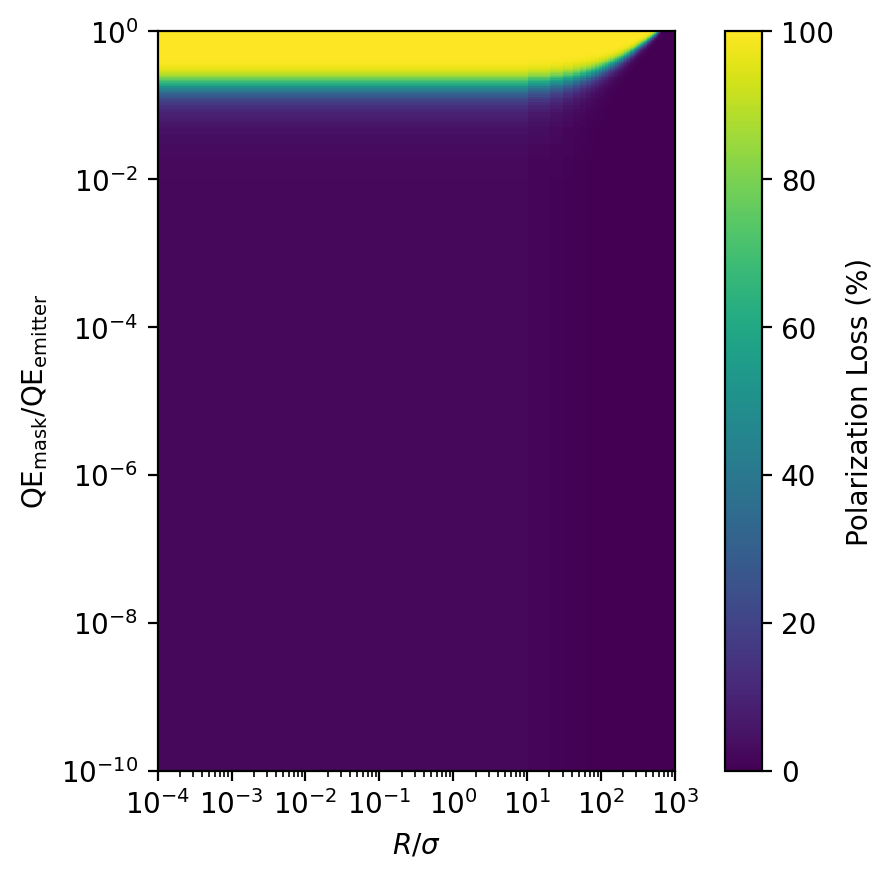

In [204]:
e1 = [np.log10(ros[0]), np.log10(ros[-1]), np.log10(qes[0]), np.log10(qes[-1])]
e1 = [ros[0], ros[-1], qes[0], qes[-1]]
#e2 = [np.log10(qes[0]), np.log10(qes[-1]), np.log10(ros[0]), np.log10(ros[-1])]
#e2 = [ros[0], ros[-1], qes[0], qes[-1]]
#plt.imshow(1-polarization/p0, extent=e1) 
plt.imshow((1-polarization/p0)*100, extent=e1, origin='lower') 
plt.colorbar(label='Polarization Loss (%)')
plt.xlabel(r'$R/\sigma$')
plt.ylabel(r'$\text{QE}_{\text{mask}}/\text{QE}_{\text{emitter}}$')
plt.xscale('log')
plt.yscale('log')

[np.float64(0.0001), np.float64(1000.0), np.float64(1e-10), np.float64(1.0)]

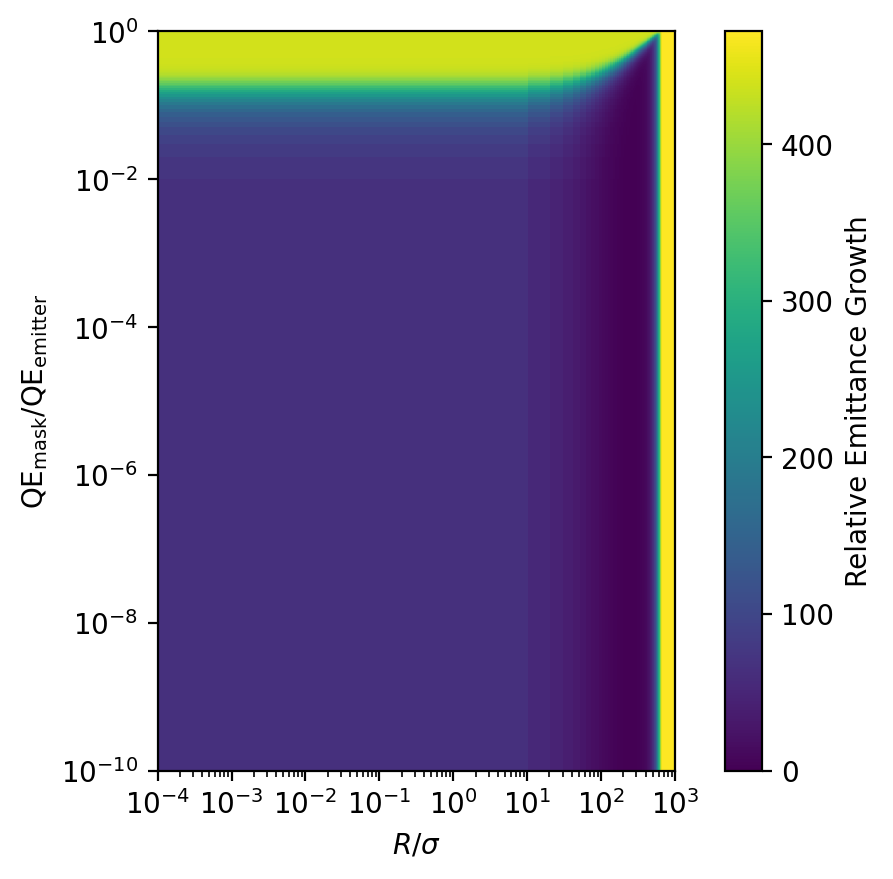

In [203]:
#e1 = [np.log10(ros[0]), np.log10(ros[-1]), np.log10(qes[0]), np.log10(qes[-1])]
e1 = [ros[0], ros[-1], qes[0], qes[-1]]
#e2 = [np.log10(qes[0]), np.log10(qes[-1]), np.log10(ros[0]), np.log10(ros[-1])]
#e2 = [ros[0], ros[-1], qes[0], qes[-1]]
#plt.imshow(1-polarization/p0, extent=e1) 
plt.imshow( (emittance/emittance.min()-1), extent=e1, origin='lower') 
plt.colorbar(label=r'Relative Emittance Growth')
plt.xlabel(r'$R/\sigma$')
plt.ylabel(r'$\text{QE}_{\text{mask}}/\text{QE}_{\text{emitter}}$')
plt.xscale('log')
plt.yscale('log')

e1

/var/folders/w8/8n1md1352pzd3nqp0lhc5jy00000gn/T/ipykernel_71039/412630202.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


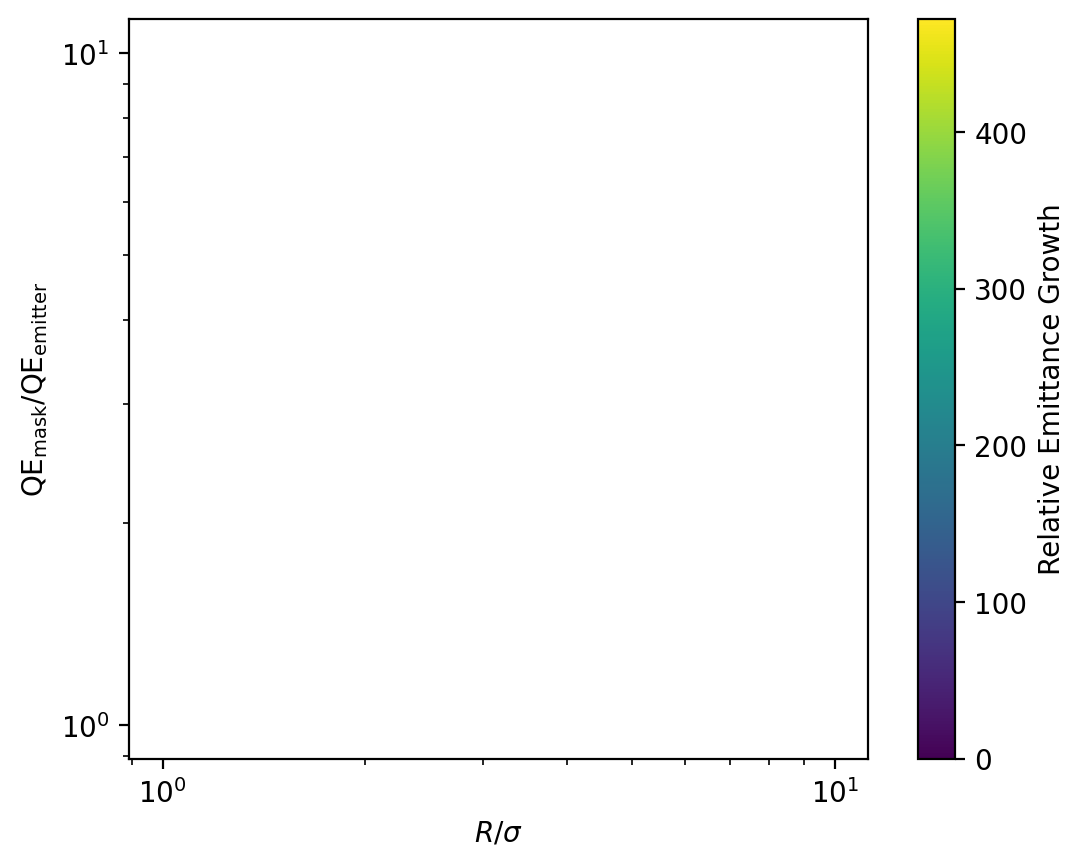

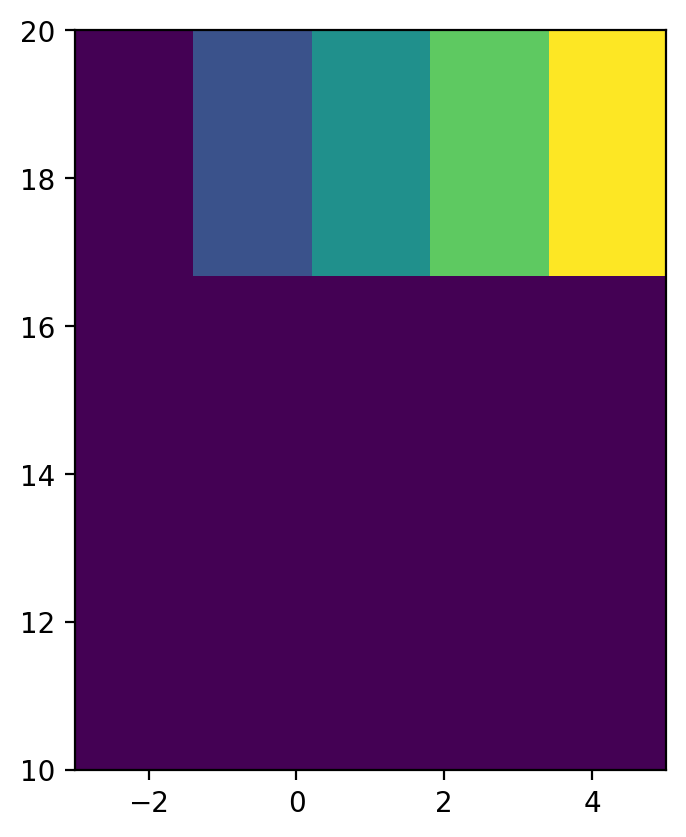

In [150]:
rho = np.zeros((3,5))

rho[0,:] = np.arange(5)

plt.imshow(rho, extent=(-3,5, 10, 20))

In [ ]:
def generate_beam_from_well2(n_particle, R, sigma, QE1, QE2, MTE):

    #laserDist = NormRad(verbose=0, **{'sigma_xy': laser_sigma_xy})
    emitterDist = NormRad(verbose=0, **{'sigma_xy': sigma, 'truncation_radius_right': R})
    maskDist = NormRad(verbose=0, **{'sigma_xy': sigma, 'truncation_radius_left': R})

    r1 = np.linspace(0, R, 1000)
    r2 = np.linspace(R, 5 * sigma, 1000)
    
    Pr1 = emitterDist.rho(r1)
    Pr2 = maskDist.rho(r2).to(Pr1.units)
    
    Pr1 = Pr1/Pr1[-1].magnitude
    Pr2 = (QE2/QE1) * (Pr1[-1]/Pr2[0]) * Pr2
    
    r = np.concatenate( (r1, r2) )
    Pr = np.concatenate( (Pr1, Pr2)) 
    norm = np.trapezoid(r*Pr, r)
    Pr = Pr/norm

    inputs = {
        'n_particle': n_particle,
        'species': 'electron',
        'r_dist': {'type': 'radial', 'r':r, 'Pr':Pr},
        'random': {'type': 'hammersley'},
        'start': {'MTE': {'value': 30, 'units': 'meV'}, 'type': 'cathode'},
        'total_charge': {'value': n_particle * 1.602176634e-19, 'units': 'C'},
        'spin_polarization': 0.35

    }

    plt.plot((r/R).to('dimensionless'), Pr * (laserDist.rho(r)[0]/Pr[0]), label='laser profile w/QE map')

    D = Generator(inputs, verbose=0)
    P = D.run()

    return P
    

In [ ]:
P2 = generate_beam_from_well2(1_000_000, 
                              emitter_radius_small, 
                              laser_sigma_xy_backside,
                              0.01, 1e-6, 
                              30 * unit_registry('meV'))

In [ ]:
P2.plot('x', 'y')

In [ ]:
P['sigma_x'], P2['sigma_x']